In [1]:
from nhlpy import *
import pandas as pd
from datetime import datetime, timedelta
import pkgutil
from scipy.stats import norm
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load Current Rankings

In [128]:
sorted_team_elo = pd.read_csv('elo_rankings.csv')

In [106]:
sorted_team_elo

,Team,Elo Score
0,WPG,1568.694550
1,VGK,1568.438168
2,NYR,1557.417047
3,VAN,1552.582254
4,DAL,1545.345970
5,FLA,1541.385779
6,CAR,1539.113540
7,LAK,1535.533428
8,BOS,1532.368772
9,COL,1523.170422


# Current Distribution of Elo Scores

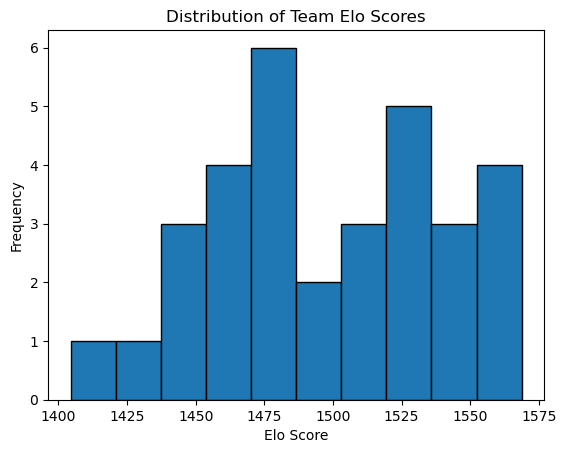

In [108]:
plt.hist(sorted_team_elo['Elo Score'], bins=10, edgecolor='black')
plt.xlabel('Elo Score')
plt.ylabel('Frequency')
plt.title('Distribution of Team Elo Scores')
plt.show()

# Load current model and create holdout (test) sample

In [129]:
validation_elo_games_df = pd.read_csv('season_elo_results.csv')
# Calculate the index to split 60% and 40% of the data
split_index = int(len(validation_elo_games_df) * 0.5)

# Select the last 40% of the season as test data
test_elo_games_df = validation_elo_games_df.iloc[split_index:].reset_index(drop=True)

## Probability distribution (home teams)

<Axes: ylabel='Frequency'>

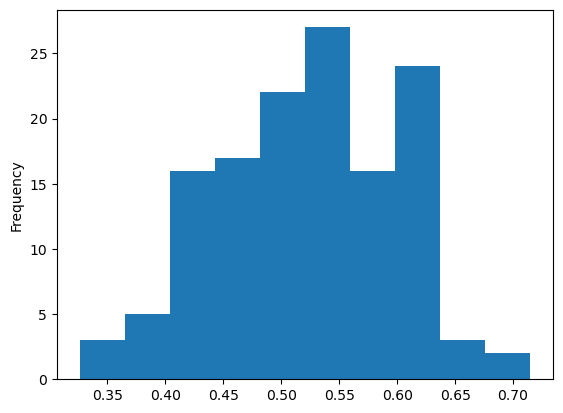

In [130]:
test_elo_games_df['home_team_prob'].plot.hist()

## Validation & Holdout data: probability means and home team win percentages

In [131]:
validation_elo_games_df['home_team_prob'].mean()

0.5182272766878205

In [132]:
validation_elo_games_df['home_team_win'].mean()

0.5464684014869888

In [133]:
test_elo_games_df['home_team_prob'].mean()

0.5240344533764841

In [134]:
test_elo_games_df['home_team_win'].mean()

0.562962962962963

## Define predicted wins (0.5 threshold)

In [135]:
# Define a threshold to classify home team win probabilities
threshold = 0.5
validation_elo_games_df['home_team_pred_win'] = np.where(validation_elo_games_df['home_team_prob'] >= threshold, 1, 0)
test_elo_games_df['home_team_pred_win'] = np.where(test_elo_games_df['home_team_prob'] >= threshold, 1, 0)

In [136]:
validation_elo_games_df['home_team_pred_win'].mean()

0.5836431226765799

In [137]:
test_elo_games_df['home_team_pred_win'].mean()

0.6296296296296297

## Confusion matrix, accuracy, precision, recall, F1

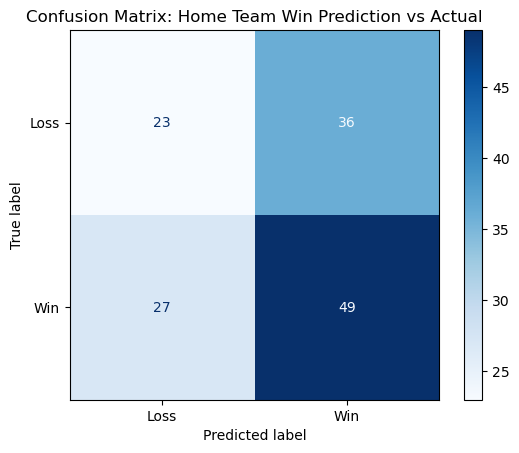

Accuracy: 0.53
Precision: 0.58
Recall: 0.64
F1 Score: 0.61


In [138]:

# Calculate the confusion matrix
cm = confusion_matrix(test_elo_games_df['home_team_win'], test_elo_games_df['home_team_pred_win'])

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Loss", "Win"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Home Team Win Prediction vs Actual")
plt.show()

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(test_elo_games_df['home_team_win'], test_elo_games_df['home_team_pred_win'])
precision = precision_score(test_elo_games_df['home_team_win'], test_elo_games_df['home_team_pred_win'])
recall = recall_score(test_elo_games_df['home_team_win'], test_elo_games_df['home_team_pred_win'])
f1 = f1_score(test_elo_games_df['home_team_win'], test_elo_games_df['home_team_pred_win'])

# Display metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")



## Season long cummulative accuracy

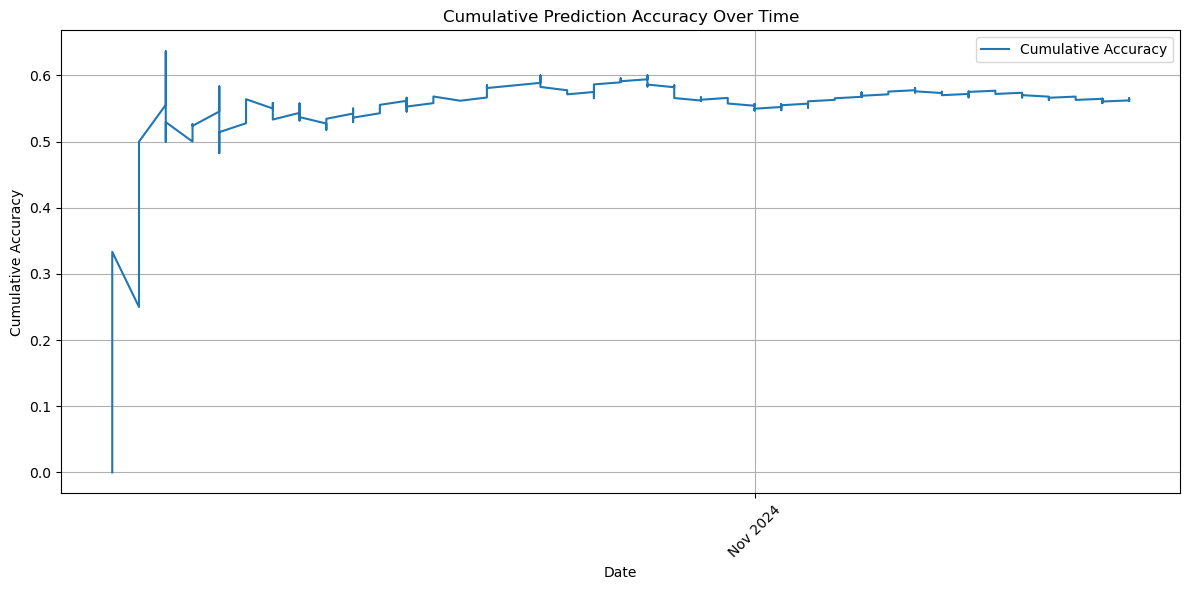

In [139]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure date column is in datetime format
validation_elo_games_df['date'] = pd.to_datetime(validation_elo_games_df['date'])

# Step 1: Calculate if each prediction was correct (1 if correct, 0 if not)
validation_elo_games_df['correct_prediction'] = (validation_elo_games_df['home_team_pred_win'] == validation_elo_games_df['home_team_win']).astype(int)

# Step 2: Calculate cumulative sum of correct predictions and cumulative count of games
validation_elo_games_df['cumulative_correct'] = validation_elo_games_df['correct_prediction'].cumsum()
validation_elo_games_df['game_count'] = validation_elo_games_df.index + 1  # Game count up to each date

# Step 3: Calculate cumulative accuracy as the ratio of cumulative correct predictions to game count
validation_elo_games_df['cumulative_accuracy'] = validation_elo_games_df['cumulative_correct'] / validation_elo_games_df['game_count']

# Plot cumulative accuracy over time
plt.figure(figsize=(12, 6))
plt.plot(validation_elo_games_df['date'], validation_elo_games_df['cumulative_accuracy'], label='Cumulative Accuracy')

# Format the x-axis to show months from October to April
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())  # Set major ticks to each month
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  # Show month and year (e.g., Oct 2023)

plt.xlabel('Date')
plt.ylabel('Cumulative Accuracy')
plt.title('Cumulative Prediction Accuracy Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Calibration Plot

C:\Users\roffm\AppData\Local\Temp\ipykernel_43136\3269444374.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  calibration_data = test_elo_games_df.groupby('prob_bin').agg(


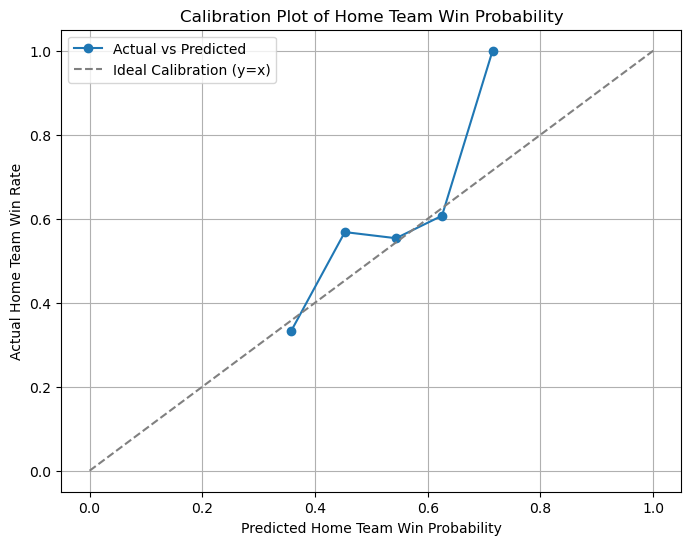

In [140]:
# Define the number of bins and bin edges for home_team_prob
num_bins = 10
test_elo_games_df['prob_bin'] = pd.cut(test_elo_games_df['home_team_prob'], bins=np.linspace(0, 1, num_bins + 1))

# Group by bins and calculate average probability and actual home team win rate in each bin
calibration_data = test_elo_games_df.groupby('prob_bin').agg(
    avg_home_team_prob=('home_team_prob', 'mean'),
    nrows = ('home_team_win', 'count'),
    actual_home_win_rate=('home_team_win', 'mean')
).dropna()

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(calibration_data['avg_home_team_prob'], calibration_data['actual_home_win_rate'], label="Actual vs Predicted", marker='o')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label="Ideal Calibration (y=x)")

# Adding labels and legend
plt.xlabel("Predicted Home Team Win Probability")
plt.ylabel("Actual Home Team Win Rate")
plt.title("Calibration Plot of Home Team Win Probability")
plt.legend()
plt.grid(True)

plt.show()

In [141]:
calibration_data

,avg_home_team_prob,nrows,actual_home_win_rate
prob_bin,,,
"(0.3, 0.4]",0.357906,6,0.333333
"(0.4, 0.5]",0.452863,44,0.568182
"(0.5, 0.6]",0.543730,56,0.553571
"(0.6, 0.7]",0.625264,28,0.607143
"(0.7, 0.8]",0.714985,1,1.000000


# Grid Search

In [63]:
import numpy as np
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import accuracy_score
import pandas as pd

season = '20222023'
standings = client.standings

standings_data = standings.get_standings(season = season)

initial_elo_df = pd.DataFrame({
    'team': [team['teamAbbrev']['default'] for team in standings_data['standings']],
    '2223_ranking': [team['leagueSequence'] for team in standings_data['standings']]
})

# Generate a normally distributed set of ELO ratings aligned with rankings
np.random.seed(1)
mean_elo = 1500
std_dev_elo = 30
n_teams = 32

# Generate ELO ratings from a normal distribution, then sort in descending order
elos = norm.rvs(loc=mean_elo, scale=std_dev_elo, size=n_teams)
elos.sort()  # Sort in ascending order for distribution from low rank to high rank

# Assign ELOs in descending order of ranking
initial_elo_df['initial_elo'] = elos[::-1]

#initial_elo_df['team'] = initial_elo_df['team'].replace('ARI', 'UTA')

# Define the season range (customize start and end dates based on the actual season)
season_start = datetime(2023, 10, 1)  # Example start date
season_end = datetime(2024, 4, 30) #- timedelta(years =1, days=1)   # Example end date

# Initialize an empty list to store game data for each day
season_games = []

# Iterate through each date in the season range
current_date = season_start
while current_date <= season_end:
    try:
        # Get schedule for the current date
        club_stats_season = client.schedule.get_schedule(date=current_date.strftime('%Y-%m-%d'))
        
        # Extract games data from the dictionary
        games_data = club_stats_season.get('games', [])
        
        # Only process dates that have games
        if games_data:
            # Parse each game's relevant information and add it to the season_games list
            for game in games_data:
                game_info = {
                    'date': club_stats_season['date'],  # Game date
                    'away_team': game['awayTeam']['abbrev'],  # Away team name
                    'away_score': game['awayTeam'].get('score', None),       # Away team score (None if missing)
                    'home_team': game['homeTeam']['abbrev'],  # Home team name
                    'home_score': game['homeTeam'].get('score', None),       # Home team score (None if missing)
                    'neutral_site': game.get('neutralSite', False),          # Neutral site indicator
                    'is_ot_so': game.get('periodDescriptor', {}).get('periodType') in ['OT', 'SO']  # OT/SO indicator
                }
                season_games.append(game_info)
    
    except KeyError as e:
        print(f"Skipping date {current_date.strftime('%Y-%m-%d')} due to missing data: {e}")
    except Exception as e:
        print(f"An error occurred on {current_date.strftime('%Y-%m-%d')}: {e}")
    
    # Move to the next date
    current_date += timedelta(days=1)

# Convert the season_games list to a DataFrame
games_df = pd.DataFrame(season_games)

team_elo = initial_elo_df.set_index('team')['initial_elo'].to_dict()

# Sort games_df by date to ensure chronological processing
elo_games_df = games_df.sort_values(by='date').reset_index(drop=True)

# Split the dataset into training and validation sets (first 50% for training, last 50% for validation)

np.random.seed(42)

# Define the range of values to test for each parameter
param_grid = {
    'K': [4, 6, 8, 10],
    'home_adv': [5, 10, 15, 25, 35, 50],
    'spread_denom': [300, 400, 500]
}

# Dictionary to store the best parameters and highest accuracy
best_params = None
best_accuracy = 0

# Iterate over all combinations of parameter values
for params in ParameterGrid(param_grid):
    # Copy the team_elo dictionary to initialize Elo ratings
    team_elo = initial_elo_df.set_index('team')['initial_elo'].to_dict()

    # Set parameters for this iteration
    K = params['K']
    home_adv = params['home_adv']
    spread_denom = params['spread_denom']
    
    # Process each game in the training set to calculate resulting Elo scores
    for idx, row in train_df.iterrows():
        away_team = row['away_team']
        home_team = row['home_team']
        
        away_starting_elo = team_elo.get(away_team, 1500)
        home_starting_elo = team_elo.get(home_team, 1500)
        
        elo_diff = home_starting_elo - away_starting_elo
        home_team_prob = 1 / (10 ** (-1 * (elo_diff + home_adv) / spread_denom) + 1)
        away_team_prob = 1 - home_team_prob
        
        if row['home_score'] > row['away_score']:
            home_win = 1
            away_win = 0
            team_win_prob = home_team_prob
        else:
            home_win = 0
            away_win = 1
            team_win_prob = away_team_prob
        
        margin_of_victory = abs(row['home_score'] - row['away_score'])
        MV_mult = 0.6686 * np.log(margin_of_victory) + 0.8048 if margin_of_victory > 1 else 1
        PreFav_mult_home = home_win - home_team_prob
        PreFav_mult_away = away_win - away_team_prob
        winner_elo_diff = abs(elo_diff)
        autocorrelation_adjustment = 2.05 / (winner_elo_diff * 0.001 + 2.05)

        train_df.at[idx, 'home_resulting_elo'] = (
            home_starting_elo + K * MV_mult * PreFav_mult_home * autocorrelation_adjustment
        )
        train_df.at[idx, 'away_resulting_elo'] = (
            away_starting_elo + K * MV_mult * PreFav_mult_away * autocorrelation_adjustment
        )

        team_elo[away_team] = train_df.at[idx, 'away_resulting_elo']
        team_elo[home_team] = train_df.at[idx, 'home_resulting_elo']
    elo_games_df['home_team_win'] = np.where(elo_games_df['home_score'] > elo_games_df['away_score'], 1, 0)
    mid_index = len(elo_games_df) // 2
    train_df = elo_games_df.iloc[:mid_index].copy()
    validation_df = elo_games_df.iloc[mid_index:].copy()
    # Now apply the model with these parameters to the validation set
    validation_df['predicted_home_win'] = validation_df.apply(
        lambda row: 1 / (10 ** (-1 * (team_elo.get(row['home_team'], 1500) - team_elo.get(row['away_team'], 1500) + home_adv) / spread_denom) + 1) >= 0.5, axis=1
    ).astype(int)

    # Calculate the accuracy on the validation set
    accuracy = accuracy_score(validation_df['home_team_win'], validation_df['predicted_home_win'])
    
    # Check if this is the best accuracy found so far
    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_params = params

# Output the best parameters and their accuracy
print(f"Best Parameters: {best_params}")
print(f"Best Validation Accuracy: {best_accuracy}")


Best Parameters: {'K': 6, 'home_adv': 15, 'spread_denom': 400}
Best Validation Accuracy: 0.6171428571428571
